# Multi-Modal Product Search with OpenSearch

This notebook demonstrates:
1. Setting up a product index with vector search capabilities
2. Ingesting product data with images
3. Performing multi-modal search using text and images

Prerequisites:
- OpenSearch cluster running with ML model (ID: dReHOZcBgoW0UZuz7inm) available
- Python 3.7+

In [1]:
# Install required packages
%pip install opensearch-py Pillow pandas requests matplotlib tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import urllib.request
import base64
from PIL import Image
import io
import json
import requests
import uuid
import os
from opensearchpy import OpenSearch, RequestsHttpConnection
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

# Create directories for data
os.makedirs('product_images', exist_ok=True)
os.makedirs('sample_queries', exist_ok=True)

In [5]:
# Helper functions for image processing
def image_to_base64(image_path):
    """Convert image to base64 string"""
    with open(image_path, 'rb') as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def display_product(product_data):
    """Display product image and details"""
    plt.figure(figsize=(8, 8))
    img_data = base64.b64decode(product_data['image'])
    img = Image.open(io.BytesIO(img_data))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{product_data['name']}\nPrice: ${product_data['price']}")
    plt.show()
    print(f"Category: {product_data['category']}")
    print(f"Description: {product_data['description']}")

def display_search_results(results):
    """Display search results in a grid"""
    hits = results['hits']['hits']
    n = len(hits)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    
    plt.figure(figsize=(15, 5*rows))
    for i, hit in enumerate(hits):
        plt.subplot(rows, cols, i+1)
        img_data = base64.b64decode(hit['_source']['image'])
        img = Image.open(io.BytesIO(img_data))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Score: {hit['_score']}\n{hit['_source']['name']}\n${hit['_source']['price']}")
    plt.tight_layout()
    plt.show()

In [7]:
# OpenSearch connection setup

try:
    client = OpenSearch(
        hosts = [{'host': '{OS HOST}', 'port': 443}],
        http_auth = ('OS_USERNAME', 'OS_PASSWORD'),
        use_ssl = True,
        verify_certs = True,
        connection_class = RequestsHttpConnection
    )
    
    # Test the connection
    client.info()
    print("✅ Successfully connected to OpenSearch cluster")
    
except Exception as e:
    print("❌ Failed to connect to OpenSearch cluster")
    raise e

✅ Successfully connected to OpenSearch cluster


## 1. Create Product Index with Vector Search

In [8]:
# Index creation with HNSW settings
index_name = "product_index"
ingest_pipeline_name = "ml_inference_pipeline_multi_modal"
index_body = {
    "settings": {
        "index": {
            "default_pipeline": ingest_pipeline_name,
            "knn": True,
            "knn.algo_param.ef_search": 100
        }
    },
    "mappings": {
        "properties": {
            "multimodal_embeddings": {
                "type": "knn_vector",
                "dimension": 1024,
                "method": {
                    "name": "hnsw",
                    "space_type": "l2",
                    "engine": "nmslib",
                    "parameters": {
                        "ef_construction": 128,
                        "m": 24
                    }
                }
            },
            "id": {"type": "keyword"},
            "name": {"type": "text"},
            "category": {"type": "keyword"},
            "description": {"type": "text"},
            "price": {"type": "float"},
            "image": {"type": "binary"},
            "current_stock": {"type": "integer"},
            "style": {"type": "keyword"},
            "gender_affinity": {"type": "keyword"},
            "where_visible": {"type": "keyword"}
        }
    }
}

# Create index
if client.indices.exists(index=index_name):
    client.indices.delete(index=index_name)
client.indices.create(index=index_name, body=index_body)
print(f"Created index: {index_name}")

Created index: product_index


## 2. Set up ML Inference Pipeline

The following code snippet creates a ML-Inference pipeline. One thing to notice here is `"model_id": "dReHOZcBgoW0UZuz7inm"`. I already created a moodel to connect with a bedrock Titan Embedding LLM. To create a model like this you can follow this blue print: https://github.com/opensearch-project/ml-commons/blob/main/docs/tutorials/ml_inference/semantic_search/bedrock_titan_multi-modal_embedding_model.md

In [8]:
# Create ML inference pipeline for ingest


ingest_pipeline_body = {
    "processors": [{
        "ml_inference": {
            "tag": "ml_inference",
            "description": "This processor is going to generate multi-model embedding during ingest",
            "model_id": "dReHOZcBgoW0UZuz7inm",
            "input_map": [{
                "inputText": "name",
                "inputImage": "image"
            }],
            "output_map": [{
                "multimodal_embeddings": "embedding"
            }],
            "ignore_missing": True,
            "ignore_failure": True
        }
    }]
}

# Create ingest pipeline
client.ingest.put_pipeline(
    id=ingest_pipeline_name,
    body=ingest_pipeline_body
)
print("Created ML inference ingest pipeline")

Created ML inference ingest pipeline


In [9]:
# Create search pipeline
search_pipeline_name = "ml_inference_pipeline_multi_modal"

search_pipeline_body = {
    "request_processors": [{
        "ml_inference": {
            "tag": "ml_inference",
            "description": "This processor is going to run ml inference during search request",
            "model_id": "dReHOZcBgoW0UZuz7inm",
            "query_template": "{\"size\": 2,\"query\": {\"knn\": {\"multimodal_embeddings\": {\"vector\": ${multimodal_embeddings},\"k\": 3}}}}",
            "optional_input_map": [{
                "inputText": "ext.ml_inference.text",
                "inputImage": "ext.ml_inference.image"
            }],
            "output_map": [{
                "multimodal_embeddings": "embedding"
            }],
            "model_config": {
                "inputImage:-null": ""
            },
            "ignore_missing": False,
            "ignore_failure": False
        }
    }]
}

# Create search pipeline
client.transport.perform_request(
    'PUT',
    f'/_search/pipeline/{search_pipeline_name}',  # Use f-string to include the variable
    body=search_pipeline_body
)
print("Created ML inference search pipeline")

Created ML inference search pipeline


## 3. Sample Product Data

In [10]:
import yaml
import os
from pathlib import Path
from tqdm import tqdm

# Set working directory to notebook location
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
os.chdir(notebook_dir)
print("Current working directory:", os.getcwd())

def load_product_catalog(yaml_file):
    """Load product catalog from YAML file"""
    with open(yaml_file, 'r') as f:
        return yaml.safe_load(f)

def prepare_product_from_file(product, image_folder):
    """Prepare product data for ingestion, including image processing from file"""
    product_copy = product.copy()
    
    # Construct image path
    image_path = os.path.join(image_folder, product_copy['category'], product_copy['image'])
    
    try:
        # Convert image to base64
        product_copy['image'] = image_to_base64(image_path)
        # Remove the original image filename
        if 'image_url' in product_copy:
            del product_copy['image_url']
        return product_copy
    except Exception as e:
        print(f"Error processing image for product {product_copy['id']}: {e}")
        return None

def ingest_products_from_files(yaml_file, image_folder):
    """Ingest products from YAML file and local images"""
    # Load product catalog
    products = load_product_catalog(yaml_file)
    
    success_count = 0
    for product in tqdm(products, desc="Ingesting products"):
        prepared_product = prepare_product_from_file(product, image_folder)
        if prepared_product:
            try:
                response = client.index(
                    index=index_name,
                    body=prepared_product,
                    id=prepared_product['id'],
                    pipeline=ingest_pipeline_name
                )
                if response['result'] == 'created':
                    success_count += 1
            except Exception as e:
                print(f"Error ingesting product {prepared_product['id']}: {e}")
    
    return success_count

# Usage
yaml_file = os.getcwd() + "/products.yaml"
image_folder = os.getcwd() + "/images"
success_count = ingest_products_from_files(yaml_file, image_folder)
print(f"Successfully ingested {success_count} products")

# Refresh index
client.indices.refresh(index=index_name)


Current working directory: /Volumes/workplace/testPythons


Ingesting products: 100%|██████████| 2465/2465 [19:33<00:00,  2.10it/s]


Successfully ingested 2465 products


{'_shards': {'total': 15, 'successful': 15, 'failed': 0}}

## 4. Search Demonstrations

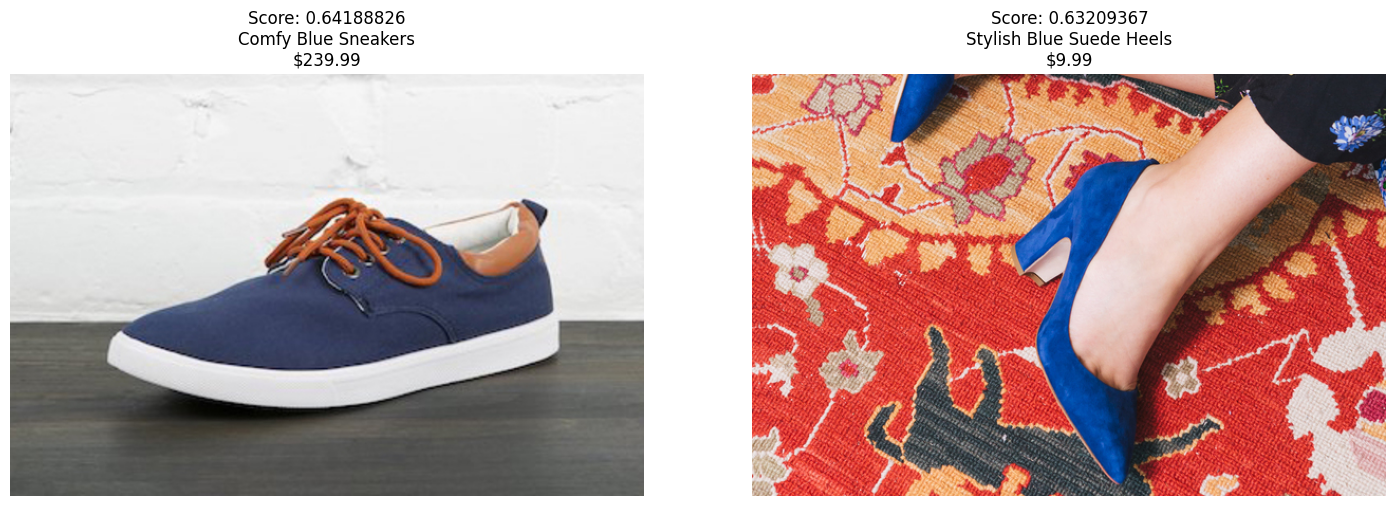

In [36]:
# Text-based search
def search_by_text(query_text):
    """Search products using text query"""
    search_body = {
        "ext": {
            "ml_inference": {
                "text": query_text
            }
        }
    }
    
    response = client.search(
        index=index_name,
        body=search_body,
        params={"search_pipeline": search_pipeline_name}  # Use the variable here
    )
    return response


# Example text search

# results = search_by_text("men's watch black")
# results = search_by_text("reloj negro masculino") # in spanish


results = search_by_text("blue shoes")
# results = search_by_text("blaue Turnschuhe") # in german

display_search_results(results)


Searching with image: red_shoe.png


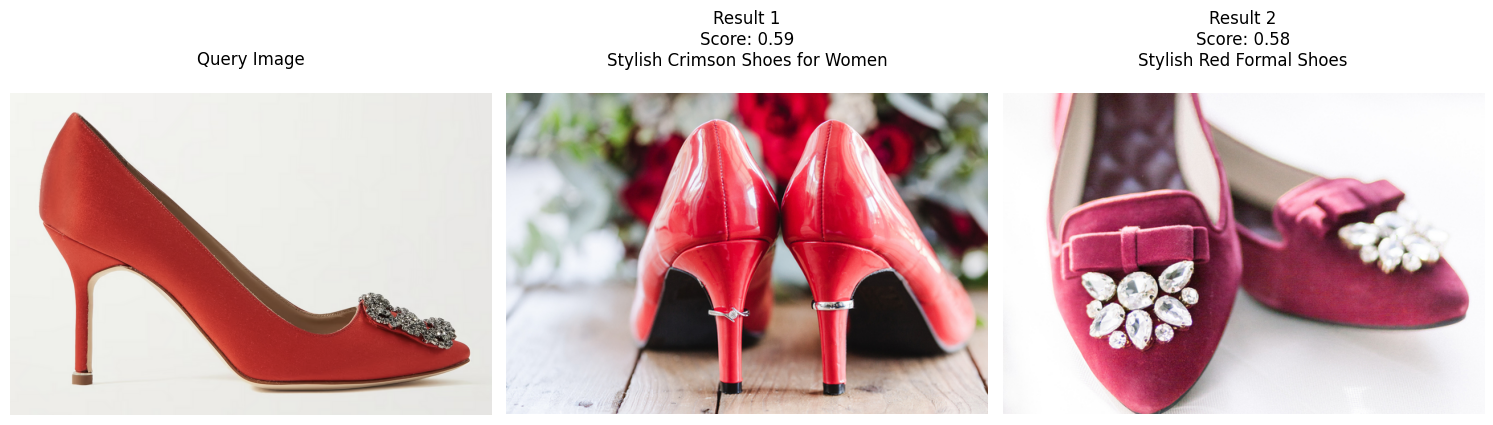

In [38]:
def display_query_and_results(query_image_path, search_results):
    """Display query image alongside search results"""
    # Calculate total number of results to display
    hits = search_results['hits']['hits']
    n_results = len(hits)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 8))
    
    # Add query image on the left
    ax1 = plt.subplot(1, 4, 1)  # 1 row, 4 cols, first position
    query_img = Image.open(query_image_path)
    ax1.imshow(query_img)
    ax1.axis('off')
    ax1.set_title('Query Image', pad=20)
    
    # Add top 3 results on the right
    for i, hit in enumerate(hits[:3], 1):  # Display top 3 results
        ax = plt.subplot(1, 4, i+1)  # 1 row, 4 cols, positions 2,3,4
        img_data = base64.b64decode(hit['_source']['image'])
        img = Image.open(io.BytesIO(img_data))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Result {i}\nScore: {hit['_score']:.2f}\n{hit['_source']['name']}", pad=20)
    
    plt.tight_layout()
    plt.show()

# Image-based search
def search_by_image(image_path):
    """Search products using image query"""
    # Convert image to base64
    image_base64 = image_to_base64(image_path)
    
    search_body = {
        "ext": {
            "ml_inference": {
                "image": image_base64
            }
        }
    }
    
    response = client.search(
        index=index_name,
        body=search_body,
        params={"search_pipeline": search_pipeline_name}
    )
    return response

# Use one of the downloaded images as a query
# sample_image_path = "black_purse.png"
sample_image_path = "red_shoe.png"

# Perform image search and display results
print(f"\nSearching with image: {sample_image_path}")
results = search_by_image(sample_image_path)
display_query_and_results(sample_image_path, results)